<h1>Deep Learning</h1>

(Small advertising: don't activate the environment from base environment, think to first deactivate)

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mlxtend.data import loadlocal_mnist
from PIL import Image
from keras.utils import np_utils
from keras.optimizers import SGD, Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.models import Sequential, load_model, save_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.datasets import cifar10

from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import backend as K
K.set_image_dim_ordering(dim_ordering="th") #we want to use Theano backend image dim order
print(K.backend()) #we use Theano as backend
#we can see that Theano is used in /media/anthony/USOPP/conda/IA/etc/conda/activate.d/keras_activate.sh

import tensorboard
%matplotlib inline
np.random.seed(seed=777)

theano


In [8]:
MNIST_PATH = '/media/anthony/USOPP/mnist_data'

MNIST dataset at <a href='http://yann.lecun.com/exdb/mnist/', target='_blank'>http://yann.lecun.com/exdb/mnist/</a>

<h2>2) Convolutionnal Neural Network</h2>

<h3>A) MNIST dataset</h3>

In [13]:
class Lenet:
    def __init__(self, input_shape, classes):
        self.model = Sequential()
        self.input_shape = input_shape
        self.classes = classes
    
    def build(self):
        self.model.add(Conv2D(filters=20, kernel_size=(5, 5), padding='same',\
                              input_shape=self.input_shape, activation='relu'))
        #self.model.add(Activation(activation="relu"))
        self.model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        self.model.add(Conv2D(filters=50, kernel_size=(5, 5), padding='same', activation='relu'))
        #self.model.add(Activation(activation="relu"))
        self.model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        self.model.add(Flatten())
        self.model.add(Dense(units=500, activation='relu'))
        #self.model.add(Activation(activation="relu"))
        self.model.add(Dense(units=self.classes, activation='relu'))
        #self.model.add(Activation(activation="softmax"))
        
        return self.model

<h4>Remarks :</h4>
<ul>
    <li><strong>'filters'</strong> is the number of convolution kernels to use</li>
    <li><strong>Increasing the number of filters in deeper layers is a common technique used in deep learning</strong></li>
</ul>

In [14]:
NB_EPOCHS = 20
BATCH_SIZE = 128
OPTIMIZER = Adam()
VALIDATION_SPLIT = 0.2
HEIGHT = WIDTH = 28
NB_CLASSES = 10

<h4>Processing :</h4>

In [15]:
X_train, Y_train = loadlocal_mnist(images_path=f'{MNIST_PATH}/train-images-idx3-ubyte',
                                   labels_path=f'{MNIST_PATH}/train-labels-idx1-ubyte')

X_test, Y_test = loadlocal_mnist(images_path=f'{MNIST_PATH}/t10k-images-idx3-ubyte',
                                 labels_path=f'{MNIST_PATH}/t10k-labels-idx1-ubyte')

#resize images
X_train = np.resize(X_train, new_shape=(X_train.shape[0], HEIGHT, WIDTH))
X_test = np.resize(X_test, new_shape=(X_test.shape[0], HEIGHT, WIDTH))
#for theano backend we need dim ordered as (batch, channels, width, height)
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

#rescale images
X_train = X_train.astype('float32') #for rescaling part
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y=Y_train, num_classes=NB_CLASSES)
Y_test = np_utils.to_categorical(y=Y_test, num_classes=NB_CLASSES)

(60000, 1, 28, 28)
(10000, 1, 28, 28)
(60000,)
(10000,)


<h4>Modelling : </h4>

In [16]:
model = Lenet(input_shape=(1, HEIGHT, WIDTH), classes=NB_CLASSES)
model = model.build()
model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 20, 28, 28)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 14, 14)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 14, 14)        25050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 7, 7)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2450)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1225500   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5010      
Total para

KeyboardInterrupt: 

In [ ]:
test_score = model.evaluate(x=X_test, y=Y_test)
print(f'Loss function minima for testing set : {test_score[0]:.3f}')
print(f'Accuracy maxima for testing set: {test_score[1]:.3f}')

train_score = model.evaluate(x=X_train, y=Y_train)
print(f'Loss function minima for training set : {train_score[0]:.3f}')
print(f'Accuracy maxima for training set: {train_score[1]:.3f}')

In [ ]:
figure = plt.figure(figsize=(15, 5))
acc = figure.add_subplot(1, 2, 1)
acc.plot(history.history['acc'], c='b', label='train')
acc.plot(history.history['val_acc'], c='r', label='test')
acc.set_title('Model accuracy')
acc.set_xlabel('epochs')
acc.set_ylabel('accuracy')
acc.legend()

loss = figure.add_subplot(1, 2, 2)
loss.plot(history.history['loss'], c='b', label='train')
loss.plot(history.history['val_loss'], c='r', label='test')
loss.set_title('Loss function')
loss.set_xlabel('epochs')
loss.set_ylabel('loss')
loss.legend()

<h3>B) CIFAR-10 dataset</h3>
Images of animals and vehicules divided in 10 classes, available at : <a href='https://www.cs.toronto.edu/~kriz/cifar.html' target='_blank'>https://www.cs.toronto.edu/~kriz/cifar.html</a>

In [19]:
IMG_CHANNEL = 3 #Because RGB images
HEIGHT = WIDTH = 32
BATCH_SIZE = 128
NB_EPOCH = 5
NB_CLASSES = 10
VALIDATION_SPLIT = 0.2
OPTIM = RMSprop() #closure

In [4]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)
(50000, 1)
(10000, 1)


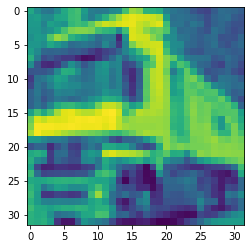

In [14]:
plt.imshow(X_train[1, 0, :, :])

In [15]:
#resizing
#for theano backend we need dim ordered as (batch, channels, width, height)
#X_train = np.moveaxis(a=X_train, source=3, destination=1)
#X_test = np.moveaxis(a=X_test, source=3, destination=1)

#rescaling
X_train = X_train.astype('float')
X_train = X_train/255
X_test = X_test.astype('float')
X_test = X_test/255

Y_train = np_utils.to_categorical(Y_train, NB_CLASSES)
Y_test = np_utils.to_categorical(Y_test, NB_CLASSES)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)
(50000, 10)
(10000, 10)


<h4>Modelling :</h4>

In [17]:
class Cifar_net:
    def __init__(self, input_shape, classes):
        self.model = Sequential()
        self.input_shape = input_shape
        self.classes = classes
    
    def build(self):
        self.model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                              activation='relu', input_shape=self.input_shape))
        self.model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                              activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(rate=0.25))
        self.model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                              activation='relu'))
        self.model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                              activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(rate=0.25))
        self.model.add(Flatten())
        self.model.add(Dense(units=512, activation='relu'))
        self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(units=self.classes, activation='softmax'))
        
        return self.model

<strong>Remarks:</strong>
<ul>
    <li>The part 'Dense + Dropout + Dense' is defined as a standard in CNN (see 'Deep Learning with Keras' book)</li>
    <li>A way to improve performance is to generate new data by simply flip, zoom, rotate, rescale, transform some image data of the traing set</li>
    </ul>

In [20]:
cifar_model = Cifar_net(input_shape=(IMG_CHANNEL, HEIGHT, WIDTH), classes=NB_CLASSES)
cifar_model = cifar_model.build()
cifar_model.summary()
cifar_model.compile(optimizer=OPTIM, loss='categorical_crossentropy', metrics=['accuracy'])
history = cifar_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, 
                          epochs=NB_EPOCH, validation_split=VALIDATION_SPLIT)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 16, 16)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 16, 16)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 8, 8)          0         
__________

In [21]:
test_score = cifar_model.evaluate(x=X_test, y=Y_test)
print(f'Loss function minima for testing set : {test_score[0]:.3f}')
print(f'Accuracy maxima for testing set: {test_score[1]:.3f}')

train_score = cifar_model.evaluate(x=X_train, y=Y_train)
print(f'Loss function minima for training set : {train_score[0]:.3f}')
print(f'Accuracy maxima for training set: {train_score[1]:.3f}')

10000/10000 [==============================] - 26s 3ms/step
Loss function minima for testing set : 0.978
Accuracy maxima for testing set: 0.657
50000/50000 [==============================] - 137s 3ms/step
Loss function minima for training set : 0.849
Accuracy maxima for training set: 0.697


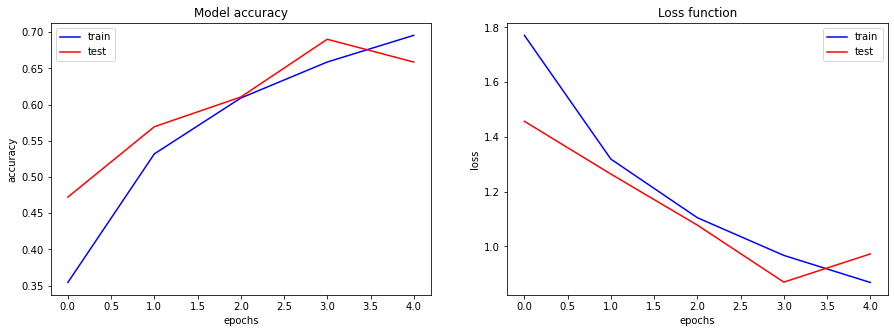

In [22]:
figure = plt.figure(figsize=(15, 5))
acc = figure.add_subplot(1, 2, 1)
acc.plot(history.history['acc'], c='b', label='train')
acc.plot(history.history['val_acc'], c='r', label='test')
acc.set_title('Model accuracy')
acc.set_xlabel('epochs')
acc.set_ylabel('accuracy')
acc.legend()

loss = figure.add_subplot(1, 2, 2)
loss.plot(history.history['loss'], c='b', label='train')
loss.plot(history.history['val_loss'], c='r', label='test')
loss.set_title('Loss function')
loss.set_xlabel('epochs')
loss.set_ylabel('loss')
loss.legend()

In [ ]:
cifar_model.save(filepath='models/cifar_model1.h5')

<h4>Predictions :</h4>

(1, 3, 32, 32)


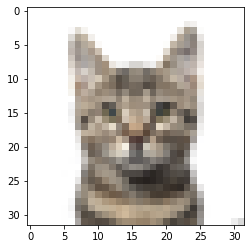

In [55]:
cat = Image.open('img/cat_face.jpeg')
cat = cat.resize(size=(32, 32))
cat = np.array(cat)
plt.imshow(cat)
cat = cat.astype('float32') / 255
cat = np.resize(cat, new_shape=(1, cat.shape[2], 32, 32))
print(cat.shape)

(1, 3, 32, 32)


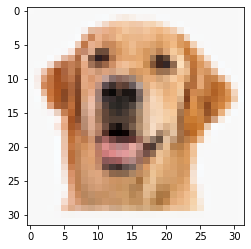

In [74]:
dog = Image.open('img/dog_face.jpeg')
dog = dog.resize(size=(32, 32))
dog = np.array(dog)
plt.imshow(dog)
dog = dog.astype('float32') / 255
dog = np.resize(dog, new_shape=(1, dog.shape[2], 32, 32))
print(dog.shape)

In [75]:
prediction = cifar_model.predict(dog)
print(prediction)
print(np.argmax(prediction))

[[0.14948429 0.20707032 0.04908258 0.04411606 0.00344662 0.00196221
  0.31909317 0.00054457 0.14917606 0.0760241 ]]
6


That's a good prediction for the dog image !